# Train MASK-RCNN

The Mask-RCNN model can be used to segment and classify two different cell types. For the code to run,  an older tensorflow version 1.x must be utilitised since the original model was created using this version. This can be achieved e.g. by using an appropriate conda environment. 

This notebook can also train on grayscale images if only pictures of the cytoplasma are given. This increases the computation speed. However, for images with nucleus channel this channel should be used as well. The changes necessary for grayscale images are indicated by '#grayscale'. 

The dataset datacells consists of 1200 images for each cell type, N2a and HEK. The data was segmented using cellpose model finetuned in the notebook cellpose.ipynb. The annotation files were converted into the right .json format using the notebook cells_to_coco.ipynb. 

Given the size of the dataset and the limited computational ressources, at this point no data augmentation techniques are used. However, they are expected to enhance the performance of the finetuned model and make it more robust. 

This notebook was created based on https://github.com/waspinator/deep-learning-explorer/tree/master/mask-rcnn and the shapes example in the MASK-RCNN github repository.

In [1]:
#import relevant packages
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2

import matplotlib
import matplotlib.pyplot as plt

#data directory
DATA_DIR = '/kaggle/input/datacells2/data-cells2'

# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'

#install pycocotools to treat data in COCO format
!pip install pycocotools

#clone mask rcnn
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!python3 setup.py install

#note that mask rcnn need tensorflow version 1.x to work, hence in kaggle an older notebook needed to be copied, in google colab this can be easy implemented 
#and on a local machine a special anaconda environment has to be utilised
import tensorflow as tf
print(tf.__version__)

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

  Stored in directory: /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e
Successfully built pycocotools
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 26.87 MiB/s, done.
Resolving deltas: 100% (562/562), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py 

Using TensorFlow backend.


In [2]:
import samples.coco.coco as coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
#DATA_DIR = os.path.join(ROOT_DIR, "data")
WEIGHTS_DIR = os.path.join(ROOT_DIR, "data")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [3]:
import skimage

#modify dataset to input images in grayscale
class CellsDataset(coco.CocoDataset):

    def load_image(self, image_id):
        """Load the specified image and return a [H,W] Numpy array. Before it was a [H,W,3] array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'], as_gray=True)
        image = image[..., np.newaxis]
        # If grayscale. Convert to RGB for consistency.
        #if image.ndim != 3:
        #    image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

Directory containing the input data has to be of the form: 

    DATA_DIR
    |
    |
    |___ annotations 
    |
    |--- cells_train2020
    |
    |--- cells_validate2020
    |
    |--- cells_test2020

In [4]:
#load datasets
dataset_train = coco.CocoDataset() #CellsDataset() #grayscale
dataset_train.load_coco(DATA_DIR, subset="cells_train", year="2020")
dataset_train.prepare()

dataset_validate = coco.CocoDataset() #CellsDataset()
dataset_validate.load_coco(DATA_DIR, subset="cells_validate", year="2020")
dataset_validate.prepare()

dataset_test = coco.CocoDataset() #CellsDataset()
dataset_test.load_coco(DATA_DIR, subset="cells_test", year="2020")
dataset_test.prepare()

loading annotations into memory...
Done (t=1.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


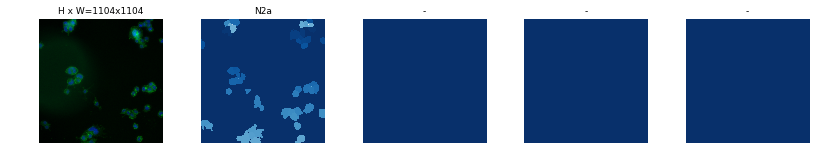

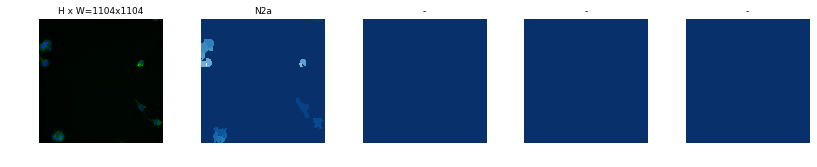

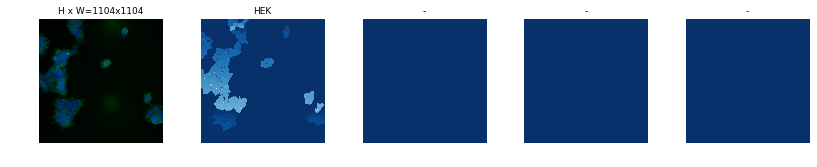

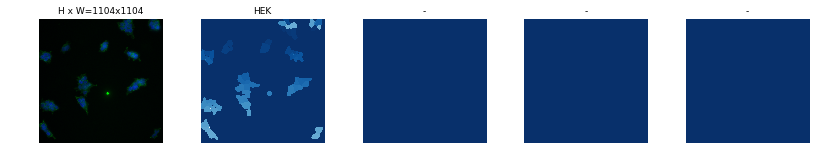

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    #visualize.display_top_masks(image[:,:,0], mask, class_ids, dataset_train.class_names) #grayscale
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [6]:
# Adjust configuration file for the images
# E.g. the images are reduced in size when input etc.

image_size = 512
rpn_anchor_template = (1, 2, 4, 8, 16) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class CellsConfig(Config):
    """Configuration for training on the cells dataset.
    """
    NAME = "cells"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 cell types (MEF, HEK)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200#100 #32

    # Input grayscale images
    #IMAGE_CHANNEL_COUNT = 1
    #MEAN_PIXEL = 1

    STEPS_PER_EPOCH = 100

    VALIDATION_STEPS = STEPS_PER_EPOCH / 20
    
config = CellsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Training

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Load weights, either start with imagenet or coco weights or start with last weights 

In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])#, "conv1"]) #grayscale
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
#can also load manually created weights via 
model.load_weights('/kaggle/input/mrcnn-weights/mask_rcnn_cells_0064.h5', by_name=True)

Train in two step process: First only the head branches and then the full network. 

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            #layers=r"(conv1)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)") #grayscale
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /kaggle/working/logs/cells20210327T1330/mask_rcnn_cells_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


In [ ]:
# necessary to download weights from training directory, otherwise irrelevant
import os
os.rename('/kaggle/working/logs/cells20210310T1243/mask_rcnn_cells_0020.h5', '/kaggle/working/mask_rcnn_cells_0030.h5')

At the current setting with 100 steps per epoch, 8 images per GPU and an image size of (256, 256, 3) the code takes ~22 min for one epoch training on the heads.

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

# Inference

In [11]:
class InferenceConfig(CellsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model.load_weights('/kaggle/input/mrcnn-weights/mask_rcnn_cells_0064.h5', by_name=True)
#print(model.find_last()[1])
#model_path = model.find_last()

# Load trained weights
#assert model_path != "", "Provide path to trained weights"
#print("Loading weights from ", model_path)
#model.load_weights(model_path, by_name=True)

Processing 1 images
image                    shape: (1104, 1104, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1104.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


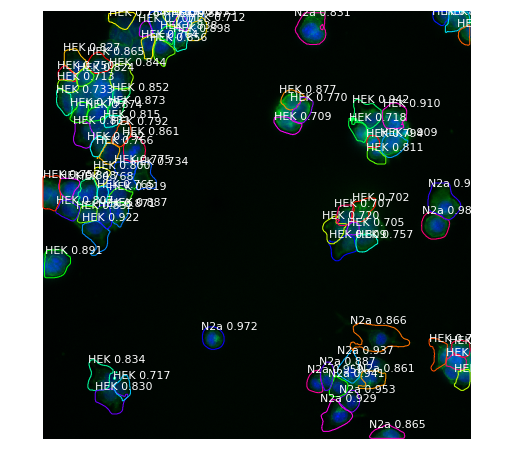

In [12]:
original_image = skimage.io.imread('/kaggle/input/mixed-images/Mixed_0011_merged.png')

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_validate.class_names, r['scores'], ax=get_ax(), show_bbox=False, show_mask=False)

In [13]:
#determine the ratio of HEK vs N2a cells detected in the mixed images and compare with predicted 50% of each celltype
import time

HEKnum = 0
N2anum = 0
totnum = 0
count = 0
start = time.time()
for path, directories, files in os.walk('/kaggle/input/mixed-images/'):
    files.sort()
    for file in files:
        original_image = skimage.io.imread(path + file)
        results = model.detect([original_image], verbose=0)
        r = results[0]
        count += 1
        for c in r['class_ids']:
            if c == 1:
                HEKnum += 1
            else:
                N2anum += 1
            totnum += 1
end = time.time()
print('Finished', count, 'images. Took', end-start, 'seconds.')
print('Percentage of HEKs', HEKnum/totnum)
print('Percentage of N2as', N2anum/totnum)

Finished 93 images. Took 331.3262872695923 seconds.
Percentage of HEKs 0.49567922571724854
Percentage of N2as 0.5043207742827515


(-0.5, 1103.5, 1103.5, -0.5)

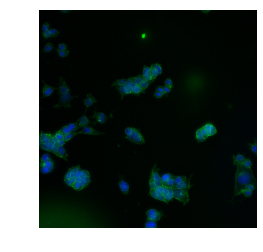

In [14]:
plt.imshow(original_image); plt.axis('off')

original_image           shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1104.00000  float64
gt_class_id              shape: (53,)                 min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (53, 4)               min:    0.00000  max:  491.00000  int32
gt_mask                  shape: (512, 512, 53)        min:    0.00000  max:    1.00000  bool


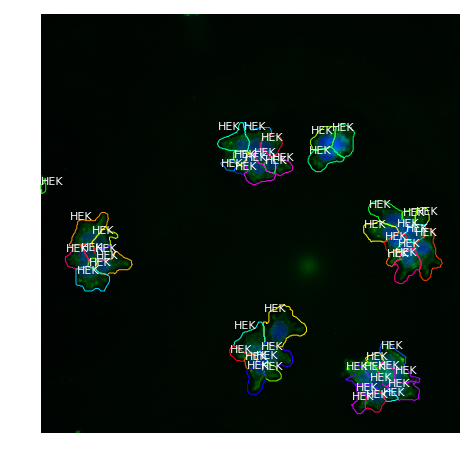

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


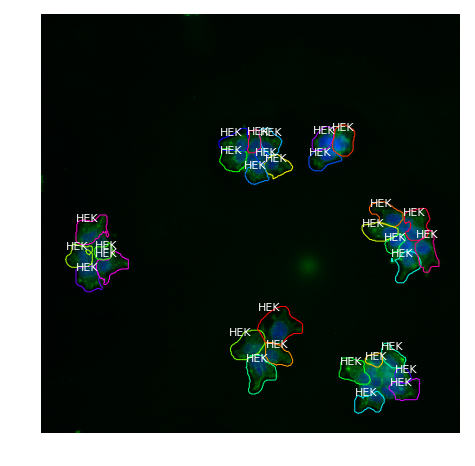

In [15]:
#compare prediction with actual output for a random image from the test dataset

image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id) #removed 'use_mini_mask=False'

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#rgb_image = skimage.color.gray2rgb(original_image[:, :, 0]) #grayscale

rgb_image = original_image

visualize.display_instances(rgb_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8), show_bbox=False, show_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(rgb_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_validate.class_names, None, ax=get_ax(), show_bbox=False, show_mask=False)

In [17]:
# Compute VOC-Style mAP @ IoU=0.5

image_ids = np.random.choice(dataset_test.image_ids, 60)
APs = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6346803106483512


In [18]:
#define functions to estimate the precision per class

def compute_per_class_precision(gt_boxes, gt_class_ids, gt_masks,
              pred_boxes, pred_class_ids, pred_scores, pred_masks,
              class_infos, iou_threshold=0.5):
    """
        Compute per class precision
    """
    
    class_precisions = {}
    
    for class_info in class_infos:
        if class_info["name"] == "BG":
            continue
        
        class_gt_indexes = np.where(gt_class_ids == class_info["id"])
        class_gt_boxes = gt_boxes[class_gt_indexes]
        class_gt_masks = gt_masks[:, :, class_gt_indexes[0]]        
        class_gt_ids = np.full(np.size(class_gt_indexes), class_info["id"])
        
        class_pred_indexes = np.where(pred_class_ids == class_info["id"])
        class_pred_boxes = pred_boxes[class_pred_indexes]
        class_pred_masks = pred_masks[:, :, class_pred_indexes[0]]
        class_pred_scores = pred_scores[class_pred_indexes]
        class_pred_ids = np.full(np.size(class_pred_indexes), class_info["id"])
        
        if np.shape(class_gt_masks)[2] == 0 and np.shape(class_pred_masks)[2] == 0:
            continue   

        if np.shape(class_gt_masks)[2] == 0:
            class_gt_indexes = (np.array([0]),)
            class_gt_boxes = np.array([[1, 1, 1, 1]])
            class_gt_masks =  np.zeros([np.shape(class_gt_masks)[0], np.shape(class_gt_masks)[1], 1])
            class_gt_ids = np.full(np.size(class_gt_indexes), class_info["id"])

        if np.shape(class_pred_masks)[2] == 0:
            class_pred_indexes = (np.array([0]),)
            class_pred_masks =  np.zeros([np.shape(class_gt_masks)[0], np.shape(class_gt_masks)[1], 1])
            class_pred_boxes = np.array([[1, 1, 1, 1]])
            class_pred_scores = np.array([0])
            class_pred_ids = np.full(np.size(class_pred_indexes), class_info["id"])
 
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(class_gt_boxes, class_gt_ids, class_gt_masks,
                            class_pred_boxes, class_pred_ids, class_pred_scores, class_pred_masks,
                            iou_threshold)
        
        class_precisions[class_info["name"]] = {
            "average_precision": AP,
            "precisions": precisions,
            "recalls": recalls,
            "overlaps": overlaps
        }
    
    return class_precisions

def compute_multiple_per_class_precision(model, inference_config, dataset, 
                                        number_of_images=10, iou_threshold=0.5):
    """
        Compute per class precision on multiple images
    """

    image_ids = np.random.choice(dataset.image_ids, number_of_images, replace=False)

    class_precisions = {}

    for image_id in image_ids:
        image, _, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,
                                image_id, use_mini_mask=False)

        results = model.detect([image], verbose=0)
        r = results[0]

        class_precision_info =\
        compute_per_class_precision(gt_bbox, gt_class_id, gt_mask,
                r["rois"], r["class_ids"], r["scores"], r["masks"],
                dataset.class_info, iou_threshold)
        
        for class_name in class_precision_info:
            if class_precisions.get(class_name):
                class_precisions[class_name].append(class_precision_info[class_name]['average_precision'])
            else:
                class_precisions[class_name] = [class_precision_info[class_name]['average_precision']]
                
    return class_precisions

Comparing the precision on the different datasets can hint towards overfitting.

In [19]:
#output the precision on the test datset
predictions = compute_multiple_per_class_precision(model, inference_config, dataset_test,
                                                 number_of_images=59, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

N2a (40): 0.5386177663170424
HEK (30): 0.5081912199061128
--------
average: 0.5255778178552154


In [20]:
#output the precision on the validation datset
predictions = compute_multiple_per_class_precision(model, inference_config, dataset_validate,
                                                 number_of_images=59, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

N2a (44): 0.5750466728152202
HEK (25): 0.4833682310933711
--------
average: 0.5418298461044053


In [21]:
#output the precision on the training datset
predictions = compute_multiple_per_class_precision(model, inference_config, dataset_train,
                                                 number_of_images=59, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

N2a (29): 0.5209608528163517
HEK (39): 0.5225500557152909
--------
average: 0.5218723074201552


The mean precisions for the different cell types are similar, indicating no prediction imbalance. Moreover, there are no signs of overfitting so that the training could, in principle, be continued to further improve the performance. Given the limited computational ressources and the timeframe of this project, training was already terminated at this supoptimal performance. However, this proves how finetuning pretrained CNNs can be utilised to segment and classify different types of cells in fluorescence microscope images.